## The value the model seeks to predict is the `mvp_share` column, which represents the result of the MVP voting for each season.

### mvp_share $= \frac{PtsWon}{PtsMax}$

In [5]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

# Load the saved best model from modeling.ipynb
xgb = joblib.load('best_xgb_model.pkl')

In [6]:
# Load the dataa
df_selected = pd.read_csv('df_selected.csv')
features = list(df_selected.columns)
features.append('mvp_share')
features.append('Rank')
df_train = pd.read_csv('df_clean.csv', usecols=features)
label_col_name = "mvp_share"
labels = df_train.pop(label_col_name)
stratify = df_train.pop("Rank")
del features[10]
del features[10]
df_last = pd.read_csv('df_last.csv', usecols=features)
last_seasons = pd.read_csv('last_seasons.csv')
last_names = pd.read_csv('last_names.csv')

df_test = pd.concat([df_last, last_seasons, last_names], axis=1).reset_index(drop=True)
df_test.rename(columns={'name': 'Name'}, inplace=True)

In [7]:
#df_selected.isna().sum()
#df_train.isna().sum()
#df_last.isna().sum()
#df_test.isna().sum()

In [8]:
(X_train, X_test, y_train, y_test) = train_test_split(df_train, 
                                                      labels, 
                                                      test_size=0.2, 
                                                      shuffle=True, 
                                                      random_state=28, 
                                                      stratify=stratify)

# Convert each dataset to array
y_train = y_train.values
y_test = y_test.values
X_train = X_train.values
X_test = X_test.values

#### Use the best model from `Models.ipynb`

In [9]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.03034458355751161, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15882876989003716,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=28, ...)

### Testing

In [10]:
# Make predictions on the test data using the best model
y_pred = xgb.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R-squared:", r2)

Test MSE: 0.0022584189376174263
Test R-squared: 0.6884422646900465


---

In [12]:
dfs_n_last = []
for season_n in df_test['Season'].unique():
        df_n = df_test[df_test['Season'] == season_n].copy()
        names_n = df_n["Name"].values
        df_n.drop(['Season', 'Name'], axis="columns", inplace=True)
        feature_n = df_n.to_numpy()

        prediction = xgb.predict(feature_n)
        df_curr_season_victory = pd.DataFrame(data=feature_n, index=None, columns=features)
        df_curr_season_victory['Season'] = season_n
        df_curr_season_victory['Player'] = names_n
        df_curr_season_victory['MVP_Shares_in_%'] = prediction * 100
        dfs_n_last.append(df_curr_season_victory)
        df_curr_season_victory = df_curr_season_victory.sort_values(by=['MVP_Shares_in_%'], ascending=False, ignore_index=True)
        
        print(season_n)
        print(df_curr_season_victory[['Player', 'MVP_Shares_in_%']].head(8))
        print("=============================================================================")
        print("============================================================================\n")
        
dfs_n_last = pd.concat(dfs_n_last, ignore_index=True)
dfs_n_last.to_csv("predictions.csv", index=False, encoding="utf-8-sig")

2022
                  Player  MVP_Shares_in_%
0           Nikola Jokić        44.502495
1            Joel Embiid        31.497961
2  Giannis Antetokounmpo        28.476408
3             Trae Young        18.139431
4     Karl-Anthony Towns         6.673195
5           JaVale McGee         5.821576
6          DeMar DeRozan         5.209736
7        Dejounte Murray         3.206020

2021
             Player  MVP_Shares_in_%
0      Nikola Jokić        53.829819
1       Luka Dončić        26.836351
2    Damian Lillard        21.239836
3        Chris Paul         2.264642
4    Nikola Vučević         1.215014
5     Julius Randle         0.795693
6      Enes Freedom         0.227212
7  Montrezl Harrell         0.066974

2020
              Player  MVP_Shares_in_%
0       LeBron James        48.072163
1       Nikola Jokić        23.611076
2       James Harden        21.233191
3     Damian Lillard        17.060488
4  Jonas Valančiūnas         0.188897
5   Hassan Whiteside         0.166839
6     

---

# Compare Against True Share

In [14]:
df_pred = pd.read_csv('predictions.csv')
df_pred.rename(columns={'Player': 'name'}, inplace=True)
keep = list(df_pred.columns)
del keep[12]
keep.append('mvp_share')

df_full = pd.read_csv('mvp_data_edit.csv', usecols=keep)

# Merge df_pred with df_full on "name" and "Season" columns
merged_df = pd.merge(df_pred, df_full[['name', 'Season', 'mvp_share']], 
                     on=['name', 'Season'], how='left')

# Rename the 'mvp_share' column to 'actual' in the merged dataframe
merged_df.rename(columns={'mvp_share': 'actual', 'MVP_Shares_in_%': 'predicted'}, inplace=True)

merged_df['actual'] *= 100

In [15]:
# Define a function to format the tick labels without decimal places
def percent_formatter(x, pos):
    return f"{int(x)}%"

# Define custom colors for 'predicted' and 'actual'
custom_palette = {'predicted': '#E57200', 'actual': '#232D4B'}

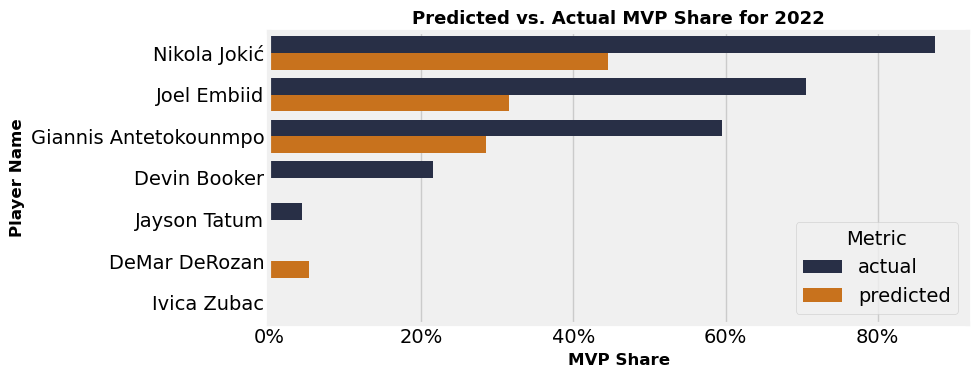

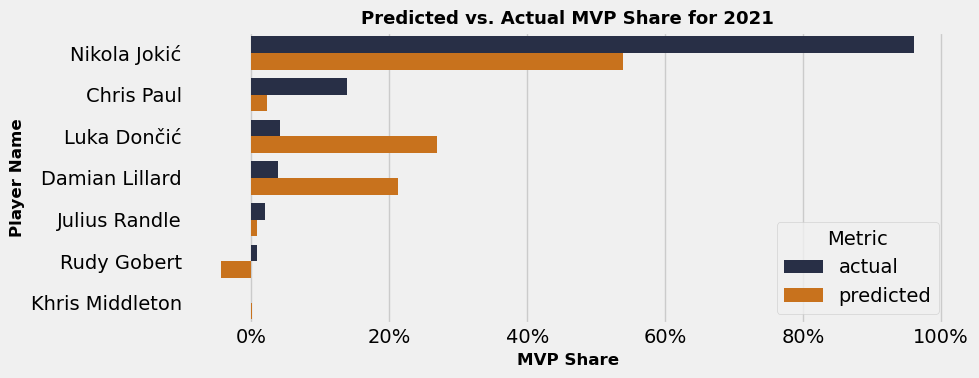

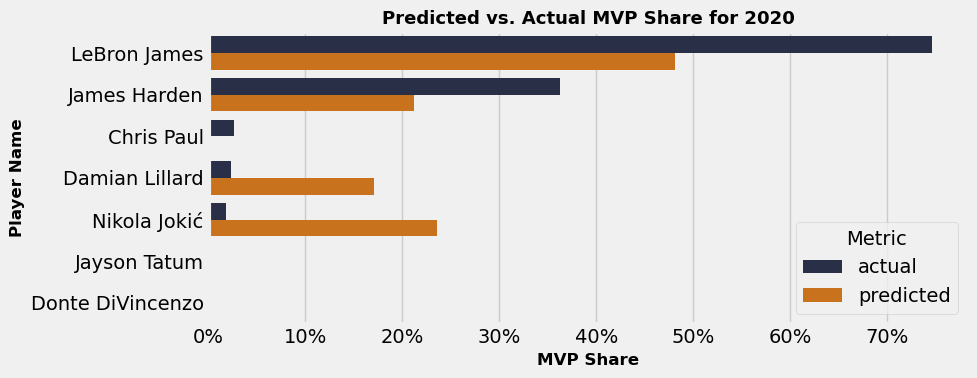

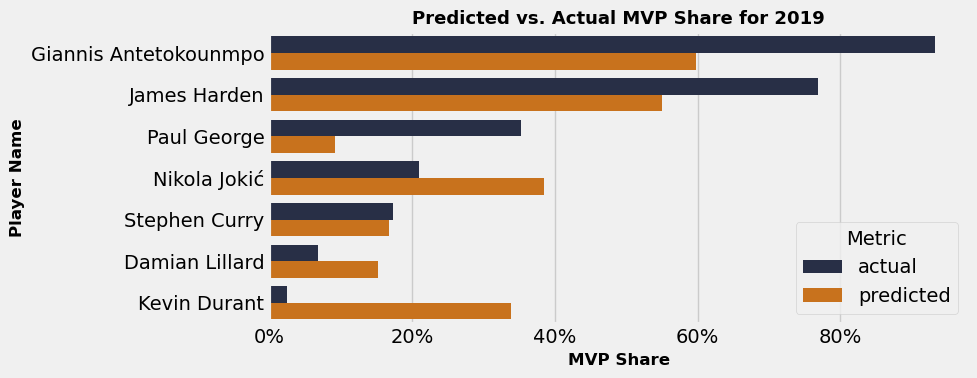

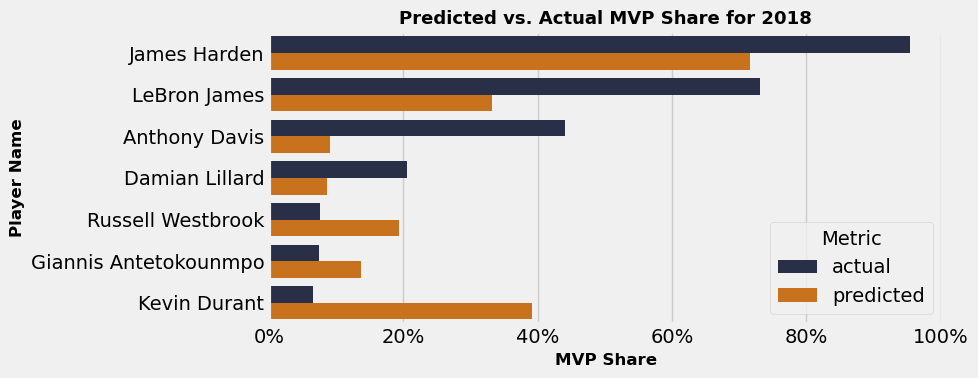

In [16]:
# Iterate over unique values in the 'Season' column and create separate plots for each
unique_seasons = merged_df['Season'].unique()

for season in unique_seasons:
    # Filter data for the current season
    season_data = merged_df[merged_df['Season'] == season]
    
    # Filter the data to include only the top 7 values of 'actual' for the current season
    top_7_actual = season_data.nlargest(7, 'actual')
    
    # Group the filtered data by 'name' and calculate mean of 'actual' and 'predicted' columns
    grouped_df = top_7_actual.groupby('name')[['actual', 'predicted']].mean().reset_index()
    
    # Sort the grouped dataframe by 'actual' values
    grouped_df.sort_values(by='actual', ascending=False, inplace=True)

    # Melt the grouped dataframe to long format for easy plotting
    melted_df = grouped_df.melt(id_vars='name', var_name='Metric', value_name='Value')

    # Plot the grouped horizontal bar chart
    plt.figure(figsize=(10, 4))
    plt.style.use('fivethirtyeight')
    ax = sns.barplot(data=melted_df, x='Value', y='name', 
                     hue='Metric', palette=custom_palette, orient='h')
    plt.xlabel('MVP Share', weight='bold', size=12)
    plt.ylabel('Player Name', weight='bold', size=12)
    plt.title(f'Predicted vs. Actual MVP Share for {season}', weight='bold', size=13)
    plt.legend(title='Metric', loc='lower right')
    ax.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
    plt.tight_layout()
    plt.show()